In [1]:
import pandas as pd
df_events = pd.read_csv("C:\\Internship\\2264002\\Microinverters\\202143051106_events.csv")
df_reading = pd.read_csv("C:\\Internship\\2264002\\Microinverters\\202143051106_readings.csv", low_memory = False)

In [2]:
df = df_reading[['date','energy_produced']].copy()

In [3]:
df['date'] = pd.to_datetime(df['date'],utc = True)

In [5]:
df['minute'] = df['date'].dt.minute
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

In [7]:
from sklearn.preprocessing import StandardScaler
scaler_energy = StandardScaler()
scaler_energy.fit(df[['energy_produced']])
df['energy_produced'] = scaler_energy.transform(df[['energy_produced']])

In [9]:
df['energy_produced'] *=10

In [11]:
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data[i:i + time_steps]
        sequences.append(seq)
    return np.array(sequences)

In [12]:
features = df[['minute', 'hour', 'day', 'month', 'energy_produced']].values

In [13]:
import numpy as np
time_steps = 20
X = create_sequences(features, time_steps)

In [58]:
model = Sequential([
    Input(shape = (X.shape[1],X.shape[2])),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu', return_sequences=False),
    RepeatVector(time_steps),
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])

In [61]:
model.compile(optimizer='adam', loss='mse')
model.fit(X, X, epochs=5, validation_split=0.1)

Epoch 1/5
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 77s 39ms/step - loss: 97.8787 - val_loss: 96.8310
Epoch 2/5
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - loss: 86.0366 - val_loss: 75.4802
Epoch 3/5
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - loss: 72.9112 - val_loss: 75.1502
Epoch 4/5
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 64s 39ms/step - loss: 70.2104 - val_loss: 68.5518
Epoch 5/5
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 71s 42ms/step - loss: 59.2864 - val_loss: 65.3558


In [17]:
X_pred = model.predict(X)

1853/1853 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


In [43]:
import joblib
joblib.dump(model, "C:\\Internship\\microinverter_model.pkl")
joblib.dump(scaler_energy, "C:\\Internship\\microinverter_scale.pkl")

['C:\\Internship\\microinverter_scale.pkl']

In [18]:
error = np.mean(np.square(X_pred - X), axis=1)
error = error[:,4]

In [19]:
error

array([ 1.12640153,  1.30419233,  1.29208464, ..., 14.97916173,
        8.5430805 ,  2.75345446])

In [20]:
from matplotlib import pyplot as plt

(array([4.0080e+04, 1.4532e+04, 3.0700e+03, 8.4300e+02, 3.8200e+02,
        2.0800e+02, 8.8000e+01, 3.0000e+01, 1.4000e+01, 7.0000e+00,
        5.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00, 1.1000e+01,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([7.89996431e-02, 1.54430316e+01, 3.08070635e+01, 4.61710955e+01,
        6.15351274e+01, 7.68991593e+01, 9.22631913e+01, 1.07627223e+02,
        1.22991255e+02, 1.38355287e+02, 1.53719319e+02, 1.69083351e+02,
        1.84447383e+02, 1.99811415e+02, 2.15175447e+02, 2.30539479e+02,
        2.45903511e+02, 2.61267543e+02, 2.76631575e+02, 2.91995606e+02,
        3.07359638e+02, 3.22723670e+02, 3.38087702e+02, 3.53451734e+02,
        3.68815766e+02, 3.84179798e+02, 3.99543830e+02, 4.14907862e+02,
        4.30271894e+02, 4.45635926e+02, 4.60999958e+02]),
 <BarContainer object of 30 

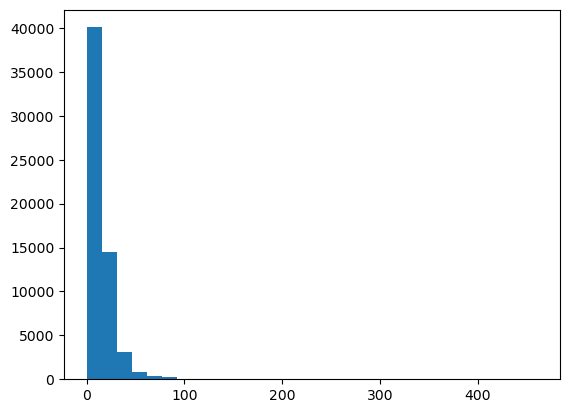

In [21]:
plt.hist(error, bins=30)

In [22]:
anomaly_df = pd.DataFrame(df[time_steps:])

In [23]:
anomaly_df['MSE'] = error

In [33]:
border = np.percentile(error,99.5)
border

82.56936460226132

In [34]:
joblib.dump(border, "C:\\Internship\\microinverter_cutoff.pkl")

['C:\\Internship\\microinverter_cutoff.pkl']

In [25]:
anomaly_df['error_cutoff'] = border

In [26]:
anomaly_df['anomaly'] = anomaly_df['MSE'] > anomaly_df['error_cutoff']

In [27]:
anomaly_df['energy_produced']/=10

In [28]:
anomaly_df['energy_produced'] = scaler_energy.inverse_transform(anomaly_df[['energy_produced']])

In [29]:
anomaly = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [30]:
anomaly_df

,date,energy_produced,minute,hour,day,month,MSE,error_cutoff,anomaly
20,2023-01-01 20:26:19+00:00,20597.548374,26,20,1,1,1.126402,82.569365,False
21,2023-01-01 20:41:42+00:00,20593.048374,41,20,1,1,1.304192,82.569365,False
22,2023-01-01 20:57:14+00:00,20593.048374,57,20,1,1,1.292085,82.569365,False
23,2023-01-01 21:12:56+00:00,20590.798374,12,21,1,1,1.117931,82.569365,False
24,2023-01-01 21:28:19+00:00,20620.048374,28,21,1,1,1.459725,82.569365,False
...,...,...,...,...,...,...,...,...,...
59309,2024-06-21 19:14:51+00:00,20575.048374,14,19,21,6,12.239384,82.569365,False
59310,2024-06-21 19:20:22+00:00,20577.298374,20,19,21,6,14.218336,82.569365,False
59311,2024-06-21 19:25:53+00:00,20577.298374,25,19,21,6,14.979162,82.569365,False
59312,2024-06-21 19:31:24+00:00,20577.298374,31,19,21,6,8.543080,82.569365,False


In [31]:
anomaly

,date,energy_produced,minute,hour,day,month,MSE,error_cutoff,anomaly
2878,2023-03-06 16:50:58+00:00,20806.798374,50,16,6,3,96.711555,82.569365,True
2880,2023-03-06 17:20:41+00:00,20950.798374,20,17,6,3,88.581049,82.569365,True
5036,2023-03-27 01:56:25+00:00,20530.048374,56,1,27,3,85.068689,82.569365,True
5037,2023-03-27 02:03:52+00:00,20530.048374,3,2,27,3,93.522523,82.569365,True
5299,2023-03-29 01:55:47+00:00,20557.048374,55,1,29,3,90.713555,82.569365,True
...,...,...,...,...,...,...,...,...,...
57562,2024-06-05 03:27:06+00:00,20525.548374,27,3,5,6,83.151344,82.569365,True
58005,2024-06-10 02:58:51+00:00,20525.548374,58,2,10,6,87.126065,82.569365,True
58028,2024-06-10 03:30:23+00:00,20525.548374,30,3,10,6,90.999589,82.569365,True
58029,2024-06-10 12:59:55+00:00,20525.548374,59,12,10,6,90.537158,82.569365,True


C:\Users\adity\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adity\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date', ylabel='energy_produced'>

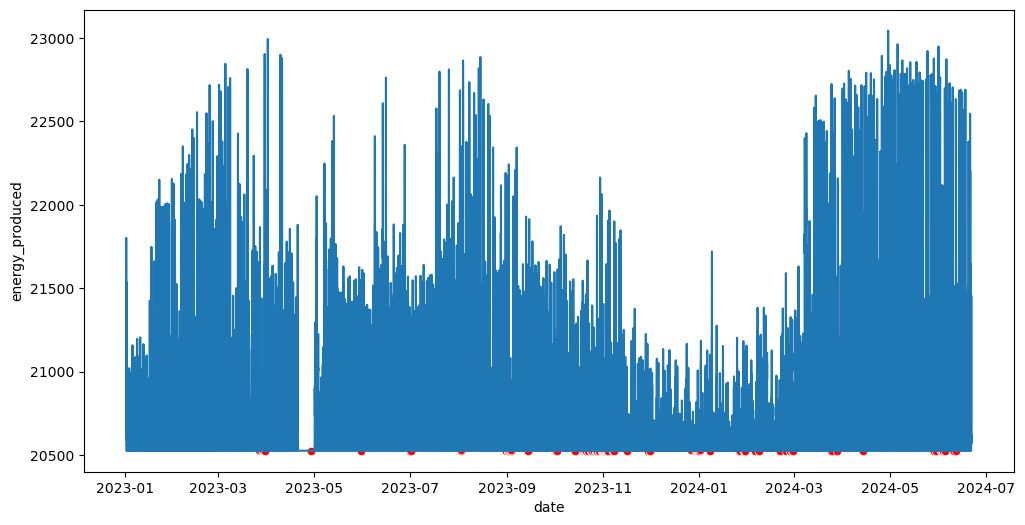

In [32]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.lineplot(x=anomaly_df['date'], y=anomaly_df['energy_produced'])
sns.scatterplot(x=anomaly['date'], y=anomaly['energy_produced'], color='r')